In [2]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape, test_data.shape
# SOn muy pocos datos, 404 para entrenar y 102 para testeo

((404, 13), (102, 13))

In [4]:
train_data[0]
# Cada sample es un vector con 13 características...
# such as per capita crime rate, average number of rooms per dwelling, accessibility to highways, and so on.

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [6]:
train_targets[0]  # es como el precio, en miles de dólares
train_targets[1]

42.3

In [5]:
# Problema... las componentes de train_data tienen rango muy dispares!!!
# Se suele normalizar: para cada feature we subtract the mean of the feature and divide by the standard deviation,
# so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy.

In [7]:
import numpy as np
def normalize(datos: np.ndarray) -> np.ndarray:
    mean = datos.mean(axis=0)  # para que haga la media de cada columna!!! de cada una de las 13 características
    std = datos.std(axis=0)  # es el vector con las desviaciones estándar de cada columna
    datos -= mean  # nos centra en la media, cada columna con su media
    datos /= std
    return datos

In [8]:
train_data = normalize(train_data)
test_data = normalize(test_data)

In [11]:
train_data[1]  # el mismo sample que mostramos antes, totalmente normalizado!!

array([-0.40342651,  2.99178419, -1.33391162, -0.25683275, -1.21518188,
        1.89434613, -1.91036058,  1.24758524, -0.85646254, -0.34843254,
       -1.71818909,  0.43190599, -1.32920239])

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
# Necesitaremos instanciar el modelo varias veces, así que crearemos con una función
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

In [11]:
# Observar que la capa de salida no tiene activación... esto es normal en los modelos de regresión
# por ejemplo, si utilizamo sigmoide estaríamos restringiendo entre 0 y 1, etc
# El error usado es mse: mean squared error, clásico en estos problemas de regresión!!
# Como métrica usaremos mae, mean absolute error (por ejemplo, si fuera 0.5 significaría un error absoluto de 500 dólares)

In [12]:
# Validaremos usando k-fold validation... ESTO ES PORQUE EL TRAINING ES MUY PEQUEÑO
# Y SI ENCIMA TENEMOS QUE APARTAR UN MINISET PARA VALIDAR PUES ...
# Consiste en dividir nuestro trainning data en k particiones (normalmente 4 o 5)
# instanciar k modelos idénticos, y entrenar cada uno de esos modelos con k - 1 particiones
# y validarlo con la restante... (de esa forma cada modelo se validará con 1 de las particiones
# y se entrenará con las otras k -1
# Luego como score del modelo es la media de las k scores
# Al tema...

In [14]:
k = 4  # lo normal es 4 o 5
num_val_samples = len(train_data) // k
all_scores = []  # aquí guardaremos el score de cada uno de las k evaluaciones que hagamos
num_epochs = 100
for i in range(k):
    print(f'Procesando el fold #{i}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)  # Lo del axis es para que concatene las matrices por filas...
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)  # Ponemos en silencio
    # Obtenemos el error mse, y la métrica mae
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Procesando el fold #0
Procesando el fold #1
Procesando el fold #2
Procesando el fold #3


In [16]:
all_scores

[1.9942104816436768, 2.664018392562866, 2.5027122497558594, 2.3554604053497314]

In [17]:
np.mean(all_scores)

2.3791003823280334

In [16]:
# La media es de 2400 dolares de error

In [18]:
# Hagamos a ver con más epochs... a ver si la cosa mejora...
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [19]:
# We can then compute the average of the per-epoch MAE scores for all folds
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

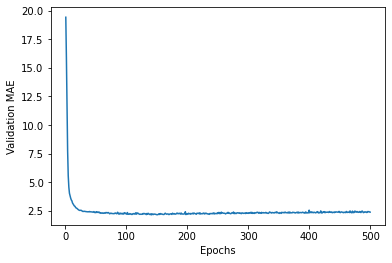

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

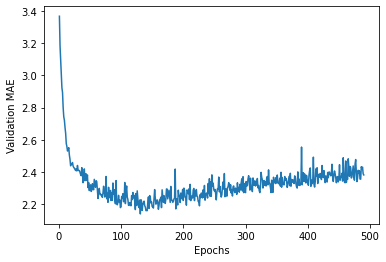

In [21]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [22]:
# Se ve que el overfitting empieza a partir más o menos de 120...

In [23]:
# Así que creemos nuestrao production model...
model = build_model()
model.fit(train_data, train_targets,
epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 0s/step - loss: 13.5187 - mae: 2.6864
